### Imports

In [91]:
import torch
import pandas as pd
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision
from torchvision.io import read_image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import save_image
from PIL import Image


import matplotlib.pyplot as plt
import os
import numpy as np

%matplotlib inline

### General Dataset Code
Contains all the code required to create and run dataset

In [2]:
os.chdir('d:\PythonProjects\ComputerVisionLearning')
cur_dir = os.getcwd()

image_path = os.path.join(cur_dir, 'images', 'StackedSetsRaw')

image_list = os.listdir(image_path)

In [151]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = torchvision.io.image.read_image(img_path)
        # Simple normalization from 0 to 1
        image[image!=0] = 1
        # Test to get rid of datatype error
        image = image.float()
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        sample = (image, label)
        return sample 

In [152]:
annotations_file = os.path.join(cur_dir, "main_project", 'vedaant', 'data_labels.csv')
img_dir = os.path.join(cur_dir, 'images', 'StackedSetsRaw')

dataset = CustomDataset(annotations_file=annotations_file, img_dir=img_dir)

In [153]:
def show_image(item):
    image = item[0]
    label = item[1]
    print(f"Label: {label}")
    img = image[0].squeeze()
    plt.imshow(img, cmap='gray')

In [154]:
dataset_len = dataset.__len__()

train_size = int(0.8*dataset_len)
test_size = dataset_len - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

### Preparing Data for Training

In [171]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))

#### Testing to ensure everything is working as intended

Feature batch shape: torch.Size([2, 1, 160, 20])
Labels batch shape: torch.Size([2])


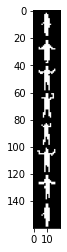

In [172]:
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')

# Each time this is run, it should display a random image
img = train_features[0].squeeze()
plt.imshow(img, cmap='gray')
plt.show()

### Defining Network

In [173]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder 
        self.enc1 = nn.Linear(in_features=3200, out_features=600)
        self.enc2 = nn.Linear(in_features=600, out_features=200)
        self.enc3 = nn.Linear(in_features=200, out_features=100)
        self.enc4 = nn.Linear(in_features=100, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)

        # Decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=100)
        self.dec3 = nn.Linear(in_features=100, out_features=200)
        self.dec4 = nn.Linear(in_features=200, out_features=600)
        self.dec5 = nn.Linear(in_features=600, out_features=3200)
    
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))

        return x



In [174]:
model = Autoencoder()
print(model)

Autoencoder(
  (enc1): Linear(in_features=3200, out_features=600, bias=True)
  (enc2): Linear(in_features=600, out_features=200, bias=True)
  (enc3): Linear(in_features=200, out_features=100, bias=True)
  (enc4): Linear(in_features=100, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=100, bias=True)
  (dec3): Linear(in_features=100, out_features=200, bias=True)
  (dec4): Linear(in_features=200, out_features=600, bias=True)
  (dec5): Linear(in_features=600, out_features=3200, bias=True)
)


In [175]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [176]:
def check_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [177]:
image_dir = os.path.join(cur_dir, 'images', 'NetworkOutput')
def make_dir():
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_img(img, epoch):
    img = img.view(img.size(0), 1, 160, 20)
    save_image(img, os.path.join(image_dir, 'Autoencoder_image{}.png'.format(epoch)))


### Training Model

In [183]:
epochs = 100

def training(model, train_dataloader, epochs):
    train_loss = []
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_dataloader:
            img, _ = data
            img = img.to(check_device())
            img = img.view(img.size(0), -1)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(train_dataloader)
        train_loss.append(loss)
        print("Epoch {} of {}, TrainLoss: {:.3f}".format(epoch+1, epochs, loss))

        if epoch %1 == 0:
            save_decoded_img(outputs.cpu().data, epoch)
    
    return train_loss

            

# training(model=model, train_dataloader=train_dataloader, epochs=epochs)


In [195]:
def test_image_reconstruct(model, test_dataloader):
    i = 0
    for batch in test_dataloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        print(img.size())
        outputs = model(img)
        outputs = outputs.view(outputs.size(0), 1, 160, 20).cpu().data
        save_image(outputs, os.path.join(image_dir, f'Reconstruction{i}.png'))
        i+=1

In [185]:
device = check_device()
model.to(device)
make_dir()

In [186]:
train_loss = training(model=model, train_dataloader=train_dataloader, epochs=epochs)

Epoch 1 of 100, TrainLoss: 0.084
Epoch 2 of 100, TrainLoss: 0.083
Epoch 3 of 100, TrainLoss: 0.083
Epoch 4 of 100, TrainLoss: 0.083
Epoch 5 of 100, TrainLoss: 0.083
Epoch 6 of 100, TrainLoss: 0.082
Epoch 7 of 100, TrainLoss: 0.083
Epoch 8 of 100, TrainLoss: 0.082
Epoch 9 of 100, TrainLoss: 0.082
Epoch 10 of 100, TrainLoss: 0.081
Epoch 11 of 100, TrainLoss: 0.080
Epoch 12 of 100, TrainLoss: 0.079
Epoch 13 of 100, TrainLoss: 0.078
Epoch 14 of 100, TrainLoss: 0.079
Epoch 15 of 100, TrainLoss: 0.079
Epoch 16 of 100, TrainLoss: 0.078
Epoch 17 of 100, TrainLoss: 0.076
Epoch 18 of 100, TrainLoss: 0.076
Epoch 19 of 100, TrainLoss: 0.076
Epoch 20 of 100, TrainLoss: 0.075
Epoch 21 of 100, TrainLoss: 0.075
Epoch 22 of 100, TrainLoss: 0.076
Epoch 23 of 100, TrainLoss: 0.075
Epoch 24 of 100, TrainLoss: 0.075
Epoch 25 of 100, TrainLoss: 0.075
Epoch 26 of 100, TrainLoss: 0.074
Epoch 27 of 100, TrainLoss: 0.073
Epoch 28 of 100, TrainLoss: 0.073
Epoch 29 of 100, TrainLoss: 0.072
Epoch 30 of 100, TrainL

<function matplotlib.pyplot.show(close=None, block=None)>

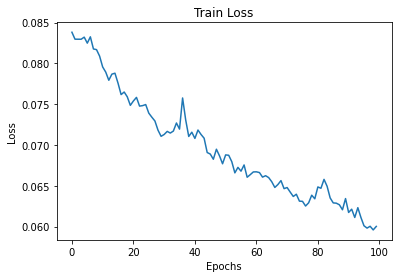

In [187]:
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show
# plt.savefig('deep_ae_mnist_loss.png')

In [196]:
test_image_reconstruct(model=model, test_dataloader=test_dataloader)

torch.Size([2, 3200])
torch.Size([2, 3200])
torch.Size([2, 3200])
torch.Size([2, 3200])
torch.Size([2, 3200])
torch.Size([2, 3200])
torch.Size([2, 3200])


In [197]:
print(test_dataloader.__len__())

7


In [198]:
torch.save(model, 'TrainedModel100Epochs.pth')
torch.save(model.state_dict(), 'TrainedModel100Epochs_weights.pth')

In [ ]:
def testing_needed_input_size()